In [7]:
import numpy as np
import control.matlab as m
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.interpolate import interp1d

# Header

In [8]:
'''
PARÂMETROS GERAIS
'''
PATH_IMAGES = Path('imagesAvl2')

param       = {'color':'lightgrey', 'linestyle':'--', 'linewidth':2, 'edgecolor':'k', 'alpha':1, 'hatch':'/'}

'''
FUNÇÕES ÚTEIS
'''
def epsf(a:float)->float:
    return np.sqrt(10**(-0.1*a) -1)

def savefig(fig:plt, name:str, format:str = 'png', dpi:int = 720, path:Path = PATH_IMAGES) -> None:
    path.mkdir(exist_ok=True)
    if not path.joinpath(f'{name}.{format}').exists():
        fig.savefig(path.joinpath(f'{name}.{format}'), format = format, dpi = dpi)

'''
FILTRO DE BUTTERWORTH
'''
def thetam (n:int)->np.ndarray:
    aux     = 0 if n%2 == 0 else 1
    mfinal  = (n-aux)/2 - 1
    m       = np.arange(0, mfinal+1)
    
    return np.pi*(2*m + n + 1)/(2*n)

def FTb(n:int, R:float)-> any:
        print(10*'-'+'BUTTERWORTH FILTER'+10*'-')
        if n > 4:
            print(f'--> Filtro reduzido de {n}th para 4th ordem')
            n = 4
        sigma_m = R*np.cos(thetam(n))
        omega_m = R*np.sin(thetam(n))
        exp     = 0 if n%2 == 0 else 1

        s  = m.tf('s')
        
        B1 = -2*sigma_m
        B2 = sigma_m**2 + omega_m**2

        aux = np.array([1])
        for i in range(len(sigma_m)):
            a   = np.array([1, B1[i], B2[i]])
            aux = np.polymul(aux,a)
        
        h1 = lambda S: sum([S**j *aux[j] for j in range(len(aux))])
        h2 = lambda S: (S+R)**(exp)
        H  = lambda S: R**(exp)*np.prod(B2)/(h1(S)*h2(S))

        # Prints
        print('\n--> Alocação dos Polos:')
        print(f'theta_m\t= {np.round(thetam(n),3)} [rad]')
        print(f'sigma_m\t= {np.round(sigma_m,3)} [u.c.]')
        print(f'omega_m\t= {np.round(omega_m,3)} [u.c.]') 
        if not n%2 == 0:
            print(f'sigma_r\t= {-R}')
        
        print(f'\n--> Função de transferência normalizada:')
        print(f'B1m\t= {np.round(B1,3)}')
        print(f'B2m\t= {np.round(B2,3)}')
        print(f'Hb\t= {H(s)}')
        return H
        



# Dados de Entrada

In [9]:
fpass   = 2772    #[Hz]
apass   = -3      #[dB]
astop   = -18     #[dB]

fstop   = fpass - 500
omegarH = fpass/fstop
omega0  = 2*np.pi*fpass
omega1  = 2*np.pi*fstop

print(f'fstop\t= {fstop} Hz')
print(f'omega0\t= {round(omega0,3)} [rad/s]')
print(f'OmegarH\t= {round(omegarH,3)}')


fstop	= 2272 Hz
omega0	= 17416.99 [rad/s]
OmegarH	= 1.22


# Filtro de Butterworth

#### --> Passa-baixas normalizado

epsilon	= 0.998
nb	= 5.195 (6th order)

----------BUTTERWORTH FILTER----------

--> Alocação dos Polos:
theta_m	= [1.963 2.749] [rad]
sigma_m	= [-0.383 -0.924] [u.c.]
omega_m	= [0.924 0.383] [u.c.]

--> Função de transferência normalizada:
B1m	= [0.766 1.849]
B2m	= [1.001 1.001]
Hb	= 
                     1.002
-----------------------------------------------
1.002 s^4 + 2.618 s^3 + 3.418 s^2 + 2.615 s + 1



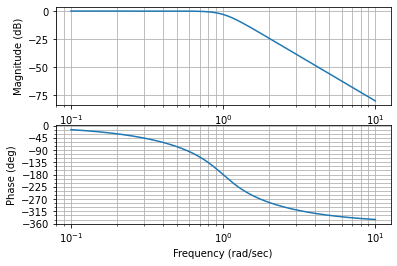

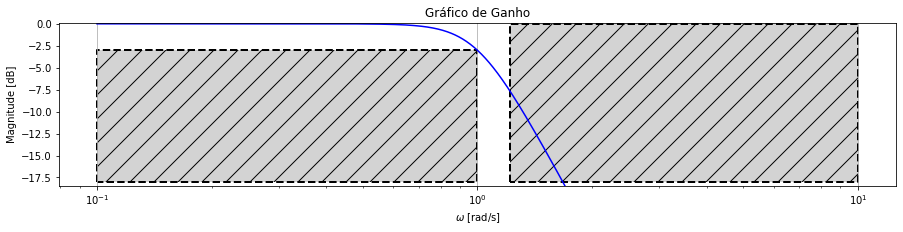

In [10]:
# fator de ajuste
eps = epsf(apass)

# ordem do filtro
nb  = np.log10(epsf(astop)/epsf(apass))/(2*np.log10(omegarH))
n   =  round(nb)+1 if not nb%1 == 0 else nb

print(f'epsilon\t= {round(eps,3)}')
print(f'nb\t= {round(nb,3)} ({n}th order)\n')

# alocação dos polos
n = n if n<=4 else 4
R = eps**(-1/(n))

# função de transferência
s   = m.tf('s')
H   = FTb(n,R)
HrL = H(s)


# Diagrama de Bode
mag, phase, omega = m.bode(HrL, plot = True)
magdB = 20*np.log10(mag)
savefig(plt.gcf(), 'bodePBnorm')
plt.show()


Xtemp = lambda x0,xf: [x0, xf]
Ytemp = lambda a0,af: [a0, af]
with plt.rc_context({'figure.figsize':(15,3)}):

    plt.semilogx(omega, magdB, 'b')
    plt.fill_between(Xtemp(omega[0], 1), Ytemp(apass, apass),Ytemp(astop,astop),**param)
    plt.fill_between(Xtemp(omegarH, 10),Ytemp(0,0),Ytemp(astop,astop), **param)
    

    plt.ylim([-18.5,0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'x')

    savefig(plt.gcf(), 'ganhoPBnorm')
    plt.show()




#### -->  Cálculo do novo valor de atenuação

astop	= -7.699dB


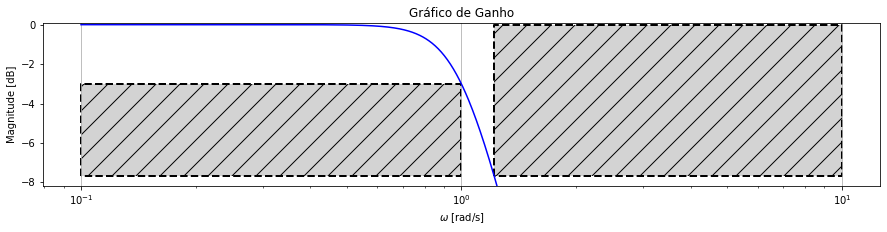

In [11]:
astopNew = -10*np.log10(omegarH**(2*n)*(10**(-0.1*apass) - 1) + 1)
print(f'astop\t= {round(astopNew,3)}dB')

with plt.rc_context({'figure.figsize':(15,3)}):

    plt.semilogx(omega, magdB, 'b')
    plt.fill_between(Xtemp(omega[0], 1), Ytemp(apass, apass),Ytemp(astopNew,astopNew),**param)
    plt.fill_between(Xtemp(omegarH, 10),Ytemp(0,0),Ytemp(astopNew,astopNew), **param)
    

    plt.ylim([-(abs(astopNew)+0.5),0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'x')
    
    savefig(plt.gcf(), 'ganhoPBnormAstop')
    plt.show()

#### --> Conversão para o filtro passa-altas

HrH	= 
                             1.002 s^10
--------------------------------------------------------------------
s^10 + 4.554e+04 s^9 + 1.037e+09 s^8 + 1.383e+13 s^7 + 9.224e+16 s^6



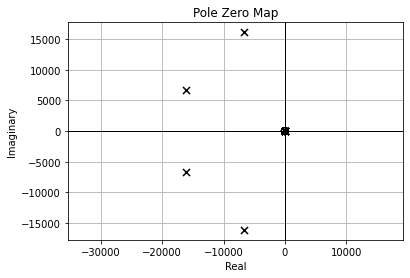

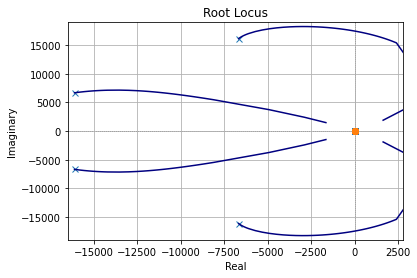

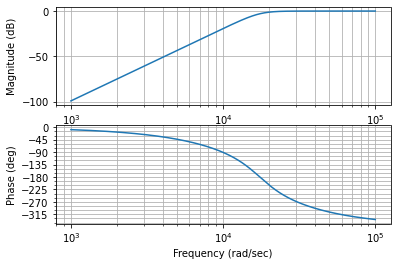

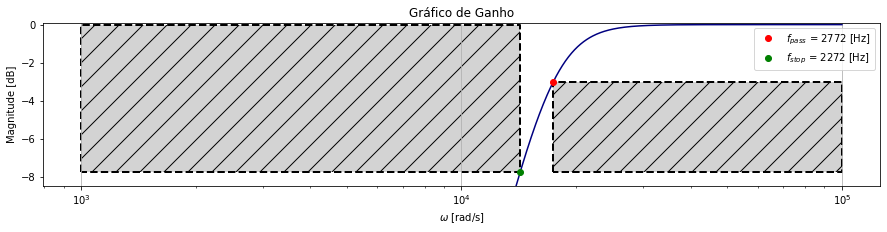

In [12]:
# Função de transferência
s = m.tf('s')
HrH = H(omega0/s)
print(f'HrH\t= {HrH}')

# Pole zero map
m.pzmap(HrH, 'b')
plt.grid()

savefig(plt.gcf(), 'pzmapPA')
plt.show()

# Root-Locus
m.rlocus(HrH, grid = False, plotstr = 'navy')
plt.grid()

savefig(plt.gcf(), 'rlocusPA')
plt.show()

# Diagrama de Bode
mag, phase, omega = m.bode(HrH, plot = True, dB = True)
magdB = 20*np.log10(mag)

savefig(plt.gcf(), 'bodePA')
plt.show()


magdBf = interp1d(omega,magdB)

with plt.rc_context({'figure.figsize':(15,3)}):
    
    plt.semilogx(omega, magdB, 'navy')
    plt.fill_between(Xtemp(omega[0], omega1), Ytemp(0, 0),Ytemp(astopNew,astopNew), **param)
    plt.fill_between(Xtemp(omega0, omega[-1]),Ytemp(apass,apass),Ytemp(astopNew,astopNew),**param)

    plt.plot(omega0, magdBf(omega0),'ro', label = r'$f_{pass}$ = '+f'{round(fpass,2)} [Hz]')    
    plt.plot(omega1, magdBf(omega1),'go', label = r'$f_{stop}$ = '+f'{round(fstop,2)} [Hz]')    
    

    plt.ylim([-(abs(astopNew)*1.1),0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'x')
    plt.legend()

    savefig(plt.gcf(), 'ganhoPA')
    plt.show()